<a href="https://colab.research.google.com/github/sheepjun96/Hands_On-Maching-Learning/blob/main/3%EC%9E%A5_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 3.1 MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

이미지가 70000개 있고 각 이미지에는 784개의 특성이 있다. 이미지가 28x28이기 때문이다. 각각의 특성은 단순히 0 (흰색)부터 255 (검은색)까지의 픽셀 강도를 나타낸다.

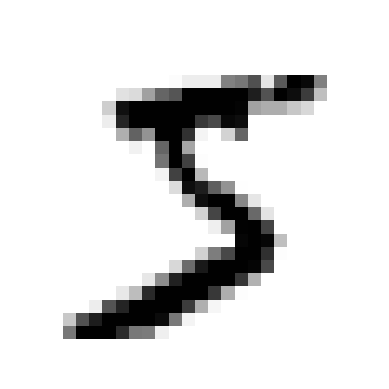

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

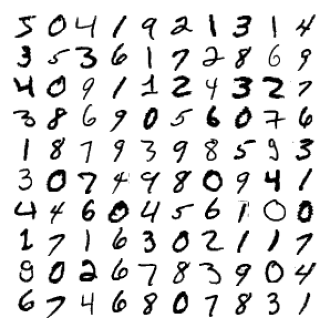

In [10]:
# 추가 코드 – 그림 3–2를 생성하고 저장합니다
plt.figure(figsize=(4, 4))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

In [12]:
y_train_5 = (y_train == '5')  # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [13]:
y_train_5

array([ True, False, False, ...,  True, False, False])

확률적 경사 하강법 SGD 분류기로 훈련해보자

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

# 교차 검증을 사용한 정확도 측정

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 이미지를 가장 많이 등장하는 클래스(여기서는 음성 클래스, 즉 "5 아님")로 분류하는 더미 분류기를 만들어 비교해보자.

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

DummyClassifier()

In [18]:
dummy_clf.predict(X_train)

array([False, False, False, ..., False, False, False])

In [19]:
print(any(dummy_clf.predict(X_train)))

False


* any() : 하나라도 True인게 있으면 True
* all() : 모두 True여야 True 반환

In [20]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 불균형 데이터셋을 다룰 때 (어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇다.

분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것이다.

# 오차 행렬

오차 행렬의 기본 아이디어는 모든 A/B 쌍에 대해 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다. 예를 들어 분류기가 숫자 8의 이미지를 0으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬에서 8번 행 0번 열을 보면 된다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 한다. 단, 테스트 세트로 예측을 만들 수 있지만, 테스트 세트는 프로젝트의 맨 마지막에 분류기가 출시 준비를 마치고 사용되므로 다른 방법을 사용한다.

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

cross_val_predict 함수는 k-폴드 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다.

이 행렬의 첫 번째 행은 '5 아님' 이미지(음성 클래스)에 대한 것으로, 53892개를 '5 아님'으로 정확하게 분류했고(진짜 음성), 나머지 687개는 '5'라고 잘못 분류했다.(거짓 양성 또는 1종 오류)

두 번째 행은 '5' 이미지(양성 클래스)에 대한 것으로, 1891개를 '5 아님'으로 잘못 분류했고(거짓 음성 또는 2종 오류) 나머지 3530개를 정확히 '5'라고 분류했다(진짜 양성).

완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 된다.

In [24]:
y_train_perfect_predictions = y_train_5     # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**정밀도**: 양성 예측의 정확도
* TP / (TP + FP), TP는 진짜 양성의 수, FP는 거짓 양성의 수

**재현율**: 정확하게 감지한 양성 샘플의 비율
* TP / (TP + FN), FN은 거짓 음성의 수

# 정밀도와 재현율

In [25]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**F1 점수**: 2/(1/정밀도 + 1/재현율) = 2 x (정밀도 x 재현율) / (정밀도 + 재현율)

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 점수가 높은 것도 중요하지만, 정밀도와 재현율의 반비례 관계로 정밀도와 재현율을 상황에 맞게 조절하는 것이 중요하다.

# 정밀도/재현율 트레이드오프

SGDClassifier가 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산한다. 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다.

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0   # 임계점

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

여기서는 SGDClassifier의 임곗값이 0이므로 predict() 메서드와 같은 결과 (즉, True)를 반환한다.

In [30]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여준다.

적절한 임곗값은 다음의 메서드를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구한 후 예측 결과가 아니라 결정 점수를 반환하도록 지정해야 한다.

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

이 점수로 함수를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
import sys

# 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

    # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')
    # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 121730 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


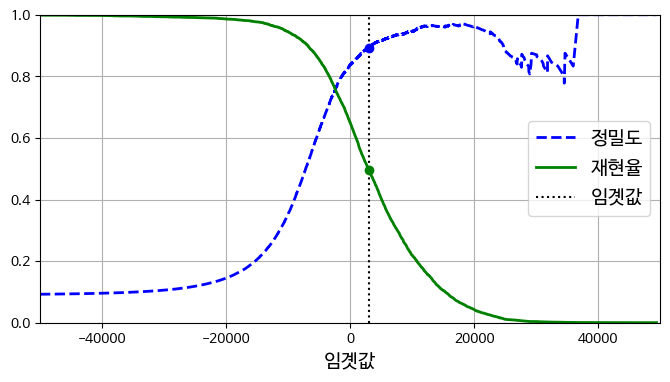

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임곗값")

idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("임곗값")
plt.legend(loc="center right")

plt.show()

이 임곗값에서 정밀도는 약 90%이고 재현율은 약 50%이다. 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.

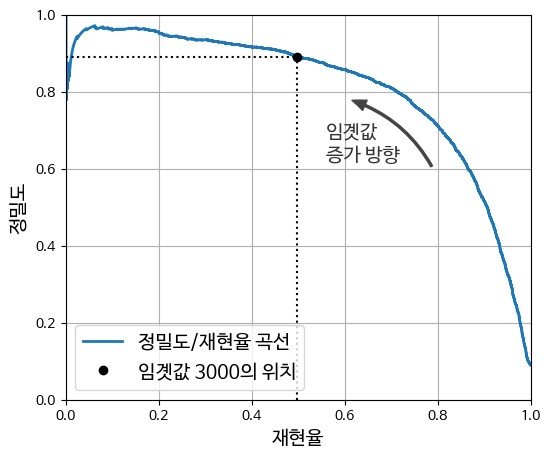

In [35]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls, precisions, linewidth=2, label="정밀도/재현율 곡선")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="임곗값 3000의 위치")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "임곗값\n증가 방향", color="#333333")
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.

정밀도 90%를 달성하는 것이 목표하고 가정하자.

In [36]:
idx_for_90_precision = (precisions >= 0.90).argmax()            # 최댓값의 첫 번 째 인덱스를 반환한다.
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

# ROC 곡선

ROC 곡선을 그리려면 여러 임곗값에서 TPR과 FPR을 계산해야 한다.

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

임곗값이 내림차순으로 정렬되어 있기 때문에 첫 번째 라인에 >=가 아니라 <=를 사용해야 한다.

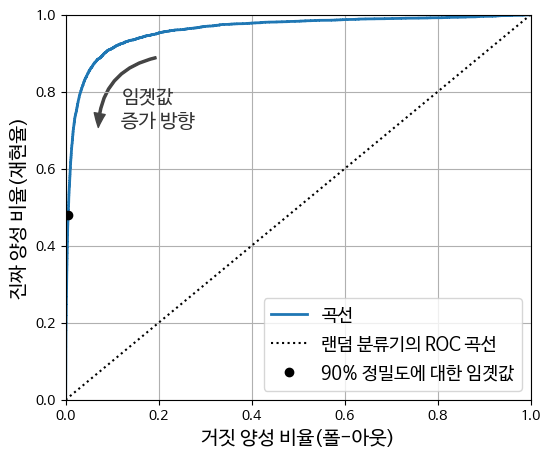

In [41]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="곡선")
plt.plot([0, 1], [0, 1], 'k:', label="랜덤 분류기의 ROC 곡선")
plt.plot([fpr_90], [tpr_90], "ko", label="90% 정밀도에 대한 임곗값")

# 추가 코드 – 그림 3–7을 그리고 저장합니다
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "임곗값\n증가 방향", color="#333333")
plt.xlabel('거짓 양성 비율(폴-아웃)')
plt.ylabel('진짜 양성 비율(재현율)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 만들어 SGDClassifier의 PR 곡선과 F1 점수를 비교한다.

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [44]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [45]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

첫 번째 이미지를 89%의 확률로 양성이라고 예측하고, 두 번째 이미지를 99% 확률로 음성이라 예측한다.

이는 _추정 확률(estimated probabilities)_입니다. 모델이 50%에서 60% 사이의 확률로 양성으로 분류한 이미지 중 실제로는 약 94%의 양성 이미지가 있습니다:

In [46]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

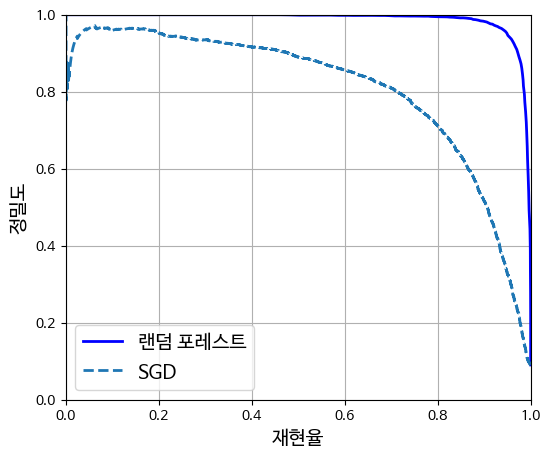

In [47]:
plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="랜덤 포레스트")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# 추가 코드 – 그림 3–8을 그리고 저장합니다
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

cross_val_predict(forest_clf, X_train, y_train_5, cv=3)을 호출하여 y_train_pred_forest을 계산할 수 있습니다. 하지만 이미 추정 확률을 가지고 있기 때문에 기본 50% 임곗값과 비교하면 훨씬 빠르게 예측을 얻을 수 있습니다:

In [48]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률 ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [50]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# 3.4 다중 분류

SVM은 대용량 데이터셋에 잘 맞지 않기 때문에 처음 2,000개의 샘플만 사용해 훈련합니다. 그렇지 않으면 아주 오랜 시간이 걸립니다:

In [52]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train_5가 아니고 y_train을 사용합니다.

SVC(random_state=42)

10개의 클래스가 있기 때문에 사이킷런은 SVC를 OvO 전략을 사용해 45개의 이진 분류기를 훈련한다.

In [53]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [55]:
class_id = some_digit_scores.argmax()
class_id

5

In [56]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [57]:
svm_clf.classes_[class_id]

'5'

decision_function()이 45개 점수를 반환하게 하려면 decision_function_shape 매개변수를 "ovo"로 지정합니다. 기본값은 "ovr"이지만 혼동하지 마세요. SVC는 항상 OvO로 훈련합니다. 이 매개변수는 45개 점수를 반환할지 여부에만 영향을 미칩니다:

In [58]:
# 추가 코드 – 45개 OvO 점수를 얻는 방법
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 다음과 같다.

In [59]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [60]:
len(ovr_clf.estimators_)

10

In [61]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

다중 분류 데이터셋에서 SGDClassifier를 훈련하고 예측을 만드는 방법은 다음과 같다.

In [62]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

예측이 틀렸다.

In [63]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

입력 스케일에 따라 예측이 다를 수도 있다.

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5 오류 분석

오차 행렬을 이용하는 방법

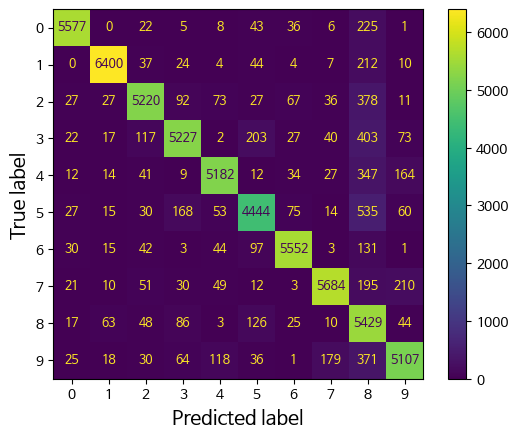

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

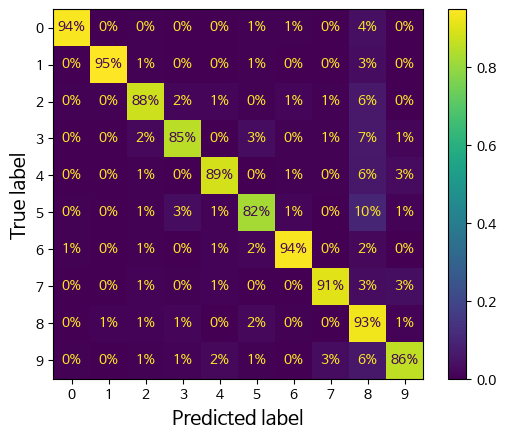

In [67]:
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

normalize='true'로 지정하여 정규화하며, values_format='.0%' 매개변수로 소수점을 없앨 수 있다.

오류를 더 눈에 띄게 만들고 싶다면 올바른 예측에 대한 가중치를 0으로 설정하면 된다.

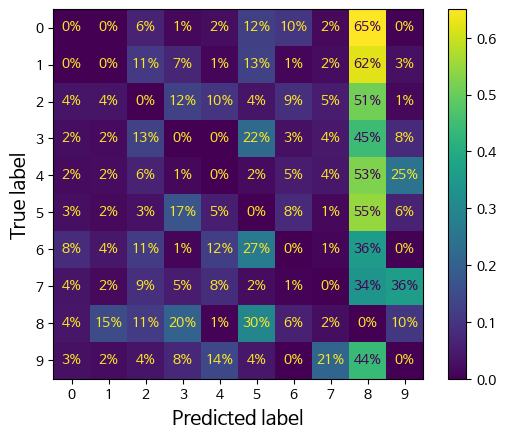

In [68]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

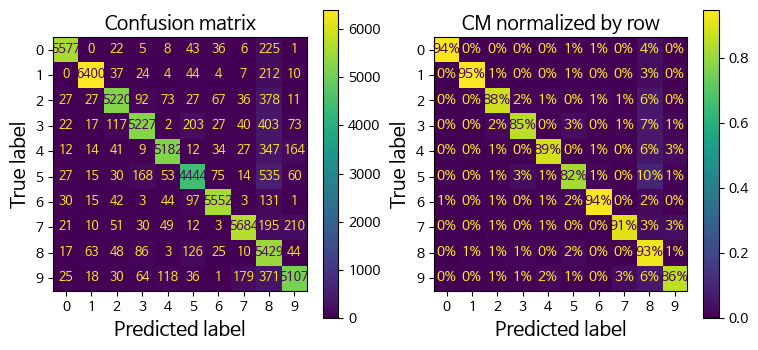

In [69]:
# 추가 코드 – 그림 3–9을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
plt.show()

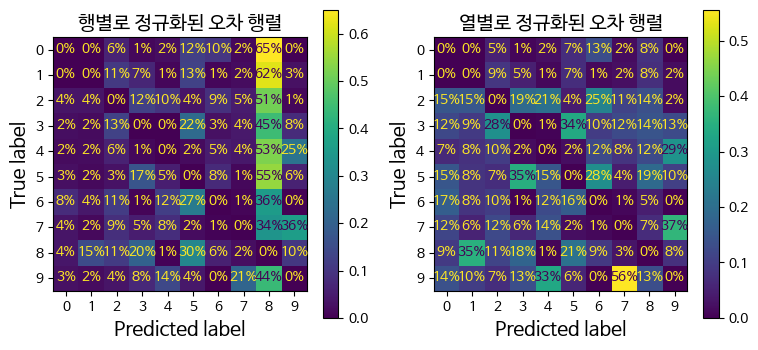

In [70]:
# 추가 코드 – 그림 3–10을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("행별로 정규화된 오차 행렬")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("열별로 정규화된 오차 행렬")
plt.show()
plt.rc('font', size=14)

# 3.6 다중 레이블 분류

In [71]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

숫자 5는 크지 않고(False), 홀수(True)이다.

# 3.7 다중 출력 분류

In [76]:
np.random.seed(42)  # 동일하게 재현되게 하려고 지정합니다
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

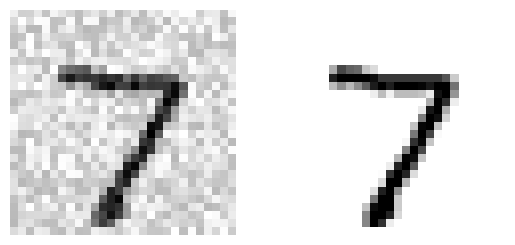

In [77]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

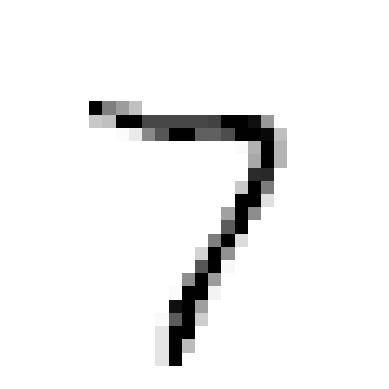

In [78]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

plt.show()